# Data Preape 

In [101]:
import matplotlib.pyplot as plt
from itertools import combinations
import pandas as pd 
import numpy as np
import random
import spacy
import re
import os

SEED = 12
PATH_BASE = 'fabricated_data/tables/fabricated_data_base.csv'
PATH_EXCTR = 'fabricated_data/tables/fabricated_data_extracted_p.csv'
PATH_SIMPLE = 'fabricated_data/tables/fabricated_data_simple_p.csv'
PATH_COMPX = 'fabricated_data/tables/fabricated_data_advance_p.csv'
PATH_ORGINAL = "Merged_data.csv"
PATH_PARAMS ='fabricated_data/Assaf_Ad_DATA - Genetic Code (parameters and types).csv'
PATH_TRI_SEM = 'fabricated_data/tables/tri_data_semantic.csv'
PATH_QUAD_TW_SEM = 'fabricated_data/tables/quad2_data_semantic.csv'
PATH_QUAUD_TH_SEM = 'fabricated_data/tables/quad3_data_semantic.csv'

#### Reading and seed intializing

In [102]:
# Read original data 
df = pd.read_csv(PATH_ORGINAL,delimiter=",")
# Read feature dictionary  
all_param_df = pd.read_csv(PATH_PARAMS).to_dict('list')
# Removing empty lines in dict
all_param_df = {k:[in_v for in_v in v if type(in_v) != float] for k,v in all_param_df.items() }
# Seeding to remove randomness
random.seed(SEED)


## Sythetic data making

In [103]:
# Remove non letters from string
def num_stripper(txt):
    return re.sub(r'[^a-zA-Z]', '', txt)

# Comparative distribution  plot
def dist_plot (prev_ctr , current_ctr, plt_nm):
    plt.title(plt_nm, fontsize = 15)
    plt.hist(current_ctr,label = 'Post_Boosting',alpha= 0.6)
    plt.hist(prev_ctr,label = 'Pre_Boosting',alpha= 0.5)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel(f'CTR \nPrior boost Variance : {round(prev_ctr.var(),2)}        Post boost Variance : {round(current_ctr.var(),2)}\nPrior Mean : {round(np.mean(prev_ctr),2)}        Post Mean : {round(np.mean(current_ctr),2)}',fontsize = 13)
    plt.ylabel('Instances',fontsize = 13)
    plt.legend(loc='upper right')
    plt.show()

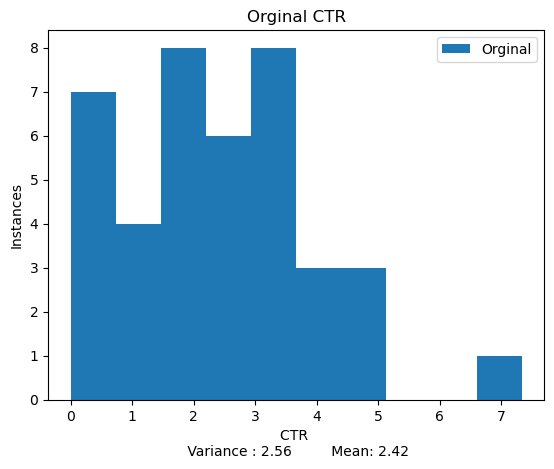

In [104]:
### Original data distribution
plt.hist(df['CTR'],label = 'Orginal')
plt.title('Orginal CTR')
plt.ylabel('Instances')
plt.xlabel(f'CTR \n Variance : {round(df["CTR"].var(),2)}         Mean: {round(df["CTR"].mean(),2)}')
plt.legend(loc='upper right')
plt.show()

In [105]:
# If exists load from fabriacted data csv
if os.path.exists(PATH_BASE) :
    random_df = pd.read_csv(PATH_BASE,delimiter=",")
else: 
    sample_number = 400
    # Defining the columns of the dataframes
    random_df = pd.DataFrame(columns= df.columns)
    # Defining CTR value ranges
    ctr_min = df['CTR'].min(axis=0)
    ctr_max = df['CTR'].max(axis=0)
    # Populating dataframe with samples
    for i in range(sample_number):
        new_row = pd.DataFrame()
        for clmn in random_df:
            # Stripping  the column name to match all_param_df
            clmn_name  = num_stripper(clmn)
            value = 0
            # Giving CTR random value within known range
            if clmn == 'CTR':
                value = random.uniform(ctr_min ,ctr_max )
            else:
                # Extracting names of duplicate columns
                dumplicate_check = [k for k in new_row.keys() if k.startswith(clmn_name)]
                # Choosing random value for new row
                value = all_param_df[clmn_name][random.randrange(0,len(all_param_df[clmn_name]))]
                # If column already exists check value isn't duplicated
                if dumplicate_check :
                    clmn_values = new_row[dumplicate_check]
                    # looping over existing values checking if they exist if they do change the current value
                    while value in clmn_values.values:
                        value = all_param_df[clmn_name][random.randrange(0,len(all_param_df[clmn_name]))]
            # Add new colmn to row df
            new_row[clmn] = [value]  
        # Concat df with new row   
        random_df = pd.concat([random_df,new_row])
    # reset index 
    random_df = random_df.reset_index()
    random_df.iloc[:,1:].to_csv(PATH_BASE, index=False,)  

## Pattern adding

### Simple pattern

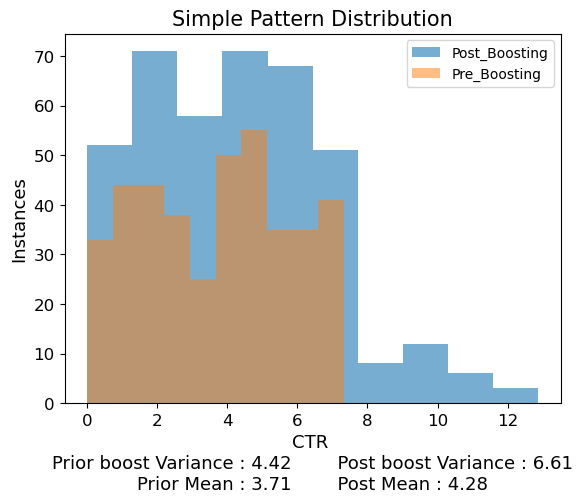

In [106]:
# Copy fabricated dataframe
df_simple = random_df.copy()
# If dataframe exist load from file
if os.path.exists(PATH_SIMPLE) :
    df_simple = pd.read_csv(PATH_SIMPLE,delimiter=",")
else:
    # Choose columns to boost
    keyword_clm  = ['Keyword','Keyword.1','Keyword.2','Keyword.3','Keyword.4']
    # Keywords boosting selection
    pattern_keys = ['design asset managment', 'projecet managment solution','Esko','pack design managment']
    ## Boosted any column that holds these keywords 
    df_simple.loc[df_simple[df_simple[keyword_clm].isin(pattern_keys).any(axis =1 )].index,'CTR'] += 5.6

    df_simple['CTR'].to_csv(PATH_SIMPLE, index=False,)  

dist_plot(random_df['CTR'],df_simple['CTR'],'Simple Pattern Distribution')


### Extracted pattern

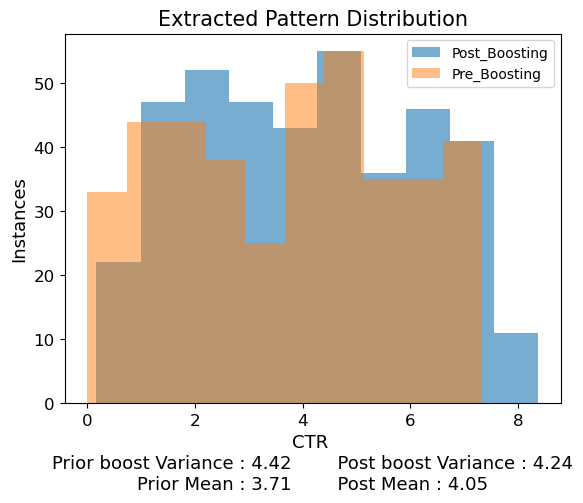

In [107]:
df_extra = random_df.copy()
if os.path.exists(PATH_EXCTR) :
    df_extra = pd.read_csv(PATH_EXCTR,delimiter=",")
else:
    # Chosing the top ten row with the highest CTR
    top10 = df.nlargest(10,['CTR'])
    # Creating a dict to hold the frequency of each term
    term_scoring = {}
    # Looping through them without the CTR included
    for cmn in top10.iloc[:,:-1]:
        # Counting term frequency 
        term_scoring[cmn] = top10[cmn].value_counts(normalize=True)
    ## Looping over columns 
    for cmn in term_scoring:
        # Looping over terms in the dictionary 
        for term in term_scoring[cmn].index:
            #Choose every row which it's column contains the specific term and boost by the frequency of it 
            df_extra.loc[df_extra[cmn].isin([term]), 'CTR'] += term_scoring[cmn][term]
            
    df_extra['CTR'].to_csv(PATH_EXCTR, index=False,)  

dist_plot(random_df['CTR'],df_extra['CTR'],'Extracted Pattern Distribution')



### Complex pattern

#### Pattern creation

In [108]:
# Number of keywords chosen from each feature 
catagroy_num = [2,7,0,3,3,0]
# Keywords boosting selection
pattern_keys = {d_key:random.sample(all_param_df[d_key],n) for d_key,n in zip(all_param_df,catagroy_num)}
pattern_keys


{'Keyword': ['digital asset software', 'packaging audit software'],
 'Description': ['Compare artwork versions. Design files always available.',
  'Artwork management automation has never been easier. Get started right now.',
  'Launch products to market faster and more accurately. Reduce recalls due to misprints.',
  'Automatic Archiving, Version Control, and Quality Assurance All in One.',
  'Set for Success with Easy Integrations. Perfect Management for Pharma, Food, Retail.',
  'Build, Configure and Automate Workflows in No Time. No Coding. Drag & Drop. ',
  'Project + Artwork Management Tool | 100% cloud-based, no download needed.'],
 'Headline': [],
 'Location': ['Netherlands, Belgium',
  'Germany, Austria',
  'Spain, France, Italy, Portugal'],
 'Sitelink': ['Integrations\n\nD: Sync 200+ Apps in One Place to Make Work Easier.',
  'Ready Made Templates\n\nD: Get Started in Minutes with Custom Worklow Templates for All Teams',
  'Project Management\n\nD: Quick Project Overview from

#### Pattern insertion 

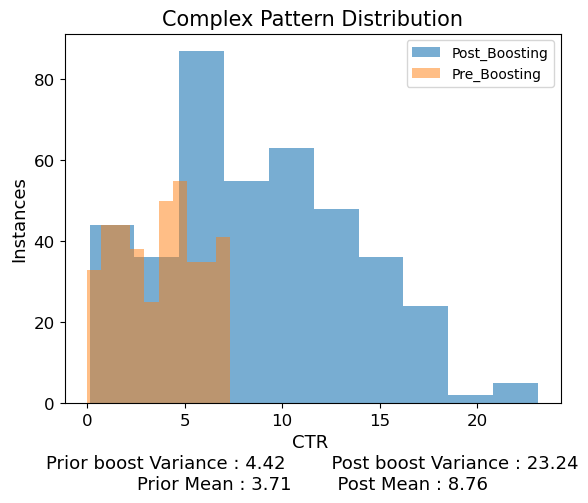

In [109]:
df_comp = random_df.copy()
if os.path.exists(PATH_COMPX) :
    df_comp = pd.read_csv(PATH_COMPX,delimiter=",")
else:
    # Removing URL and CTR for columns
    keyword_clm  = list(df.columns[:-1])
    keyword_clm.remove('Url')
    # Loop over all feature parameters and boost according  to chosen  keywords by 5 per CTR
    for key in pattern_keys:
        # Choosing every column that match the feature parameter key 
        df_clmn = [k for k in keyword_clm if k.startswith(key)]
        # Looping over all columns that match the key 
        for bost_clmn in df_clmn:
            # Boost every row that it's holds a matching pair of column and values 
            df_comp.loc[df_comp[df_comp[[bost_clmn]].isin(pattern_keys[key]).any(axis = 1)].index,'CTR'] += 5
    df_comp['CTR'].to_csv(PATH_COMPX, index=False,)  
    
dist_plot(random_df['CTR'],df_comp['CTR'],'Complex Pattern Distribution')


## Sementic pattern 

In [110]:
# Loading Word2vec dictionary for similarity  analysis 
nlp = spacy.load("en_core_web_lg")  
QUAD_THREE_PATH = 'fabricated_data/simalrty scores/quad_th_sim.csv'
TRI_PATH = 'fabricated_data/simalrty scores/tri_sim.csv'
QUAD_TWO_PATH = 'fabricated_data/simalrty scores/quad_tw_sim.csv'


In [111]:
def sim_potter (sim_range,name):
    # Flattening Similarity score  
    flat = sim_range.stack().values
    plt.title(name)
    plt.hist(flat,label = 'Simlarity_dist',alpha= 0.6)
    plt.xlabel('Simalrty Score')
    plt.ylabel('Instances')
    plt.xticks(np.arange(min(flat),max(flat),0.15))
    plt.legend(loc='upper right')
    plt.show()

def sim_corelation (df_corr,compr_ctr):
    # Adding CTR to dataframe  
    df_corr['CTR'] = compr_ctr
    # Calculating  correlation scores  
    corr_data = df_corr.corr('spearman')['CTR']
    # Print tuple combinations with correlation scores ranging between 0 and 0.1 
    print(corr_data.sort_values(ascending=False)[(corr_data < 0.1) & (corr_data > 0) ][:10])



### Multi-feature Similarity 

In [112]:
def tuple_maker(df_similarity,tuple_num):
    ## Create list of row tuple values
    tup_list = []
    ## Create combinations for every tuple_num of features in a row  
    for row in df_similarity.itertuples():
        tup_list.append(list(combinations(row[1:],tuple_num)))
    return tup_list

def similar_score(tup_list , df_similarity,tuple_num):
     ## Loop over the feature row combinations 
    result_tabl = []
    for sen in tup_list:
        tup_sim = {} 
        ## Get row from orginal df
        clmn = df_similarity.iloc[tup_list.index(sen),:]
        ## Loop over each combination of length of sen features  
        for tup in sen: 
            # Get tuple column names
            dict_clm = list(clmn.isin(tup)[lambda x : x == True].index)
            # Creating a dictionary mapping the columns to values
            dict_val = dict(zip(tup,dict_clm ))
            # Making even smaller combinations of tuple_num to tup - tuple_num 
            feature_combo = list(combinations(tup,tuple_num))
            for tup_f in feature_combo:
                # Singling out compared value that not in the tup
                sing_val  = [val for val in tup if val not in tup_f]
                # Combining column names for dict
                compare_v = " + ".join([dict_val.get(x) for x in tup_f])
                b_compare_v =  " + ".join([dict_val.get(r) for r in sing_val])
                invs_string = f'{b_compare_v} / {compare_v}'
                # Checking tuple duplucates
                if invs_string not in tup_sim:
                    interact_string = f'{compare_v} / {b_compare_v}'
                    # Joining the left part of the tuple and processing it for similarity  calculation
                    tuple_inter = nlp(' '.join(tup_f) )
                    # Joining the right part of the tuple and processing it for similarity  calculation
                    compared_vale = nlp(' '.join(sing_val))
                    # Comapring the joined pair to a single value
                    tup_sim[interact_string] = tuple_inter.similarity(compared_vale)
        result_tabl.append(tup_sim)
    return result_tabl

#### Tri Similarity

present


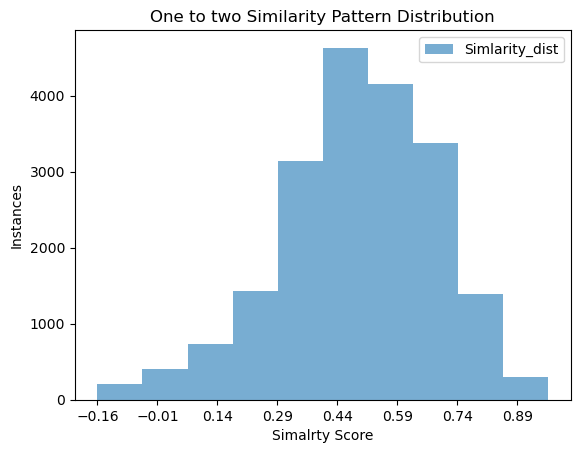

Headline + Keyword.3 / Keyword.2        0.098574
Sitelink + Keyword.1 / Keyword.4        0.095481
Headline.1 + Keyword.3 / Headline       0.095143
Sitelink + Keyword.1 / Headline.1       0.094844
Sitelink + Keyword.3 / Keyword.1        0.092634
Headline.1 + Keyword.1 / Description    0.089229
Keyword.1 + Keyword.3 / Description     0.088014
Callout.1 + Keyword / Sitelink          0.085474
Sitelink + Keyword.2 / Keyword          0.083586
Callout + Callout.1 / Keyword           0.081101
Name: CTR, dtype: float64


In [113]:
## Exclude columns with no semantics
df_similarity = df.loc[:,~df.columns.isin(['CTR', 'Url' , 'Location'])]
if os.path.exists(TRI_PATH) :
    tri_sim = pd.read_csv(TRI_PATH,delimiter=",")
    print('present')
else:
    # Making tuples of 3 features 
    tri_res = tuple_maker(df_similarity,3)
    # Caculating similarity scores for each combination of 2 to 1 features  
    tri_res = similar_score(tri_res,df_similarity,2)
    tri_sim = pd.DataFrame.from_records(tri_res)
    tri_sim.to_csv(TRI_PATH, index=False,)   
# Plotting Similarity distribution  
sim_potter (tri_sim,'One to two Similarity Pattern Distribution')
# Showing Correlation scores  
sim_corelation (tri_sim.copy() ,df['CTR'])

#### Quad similarity

present


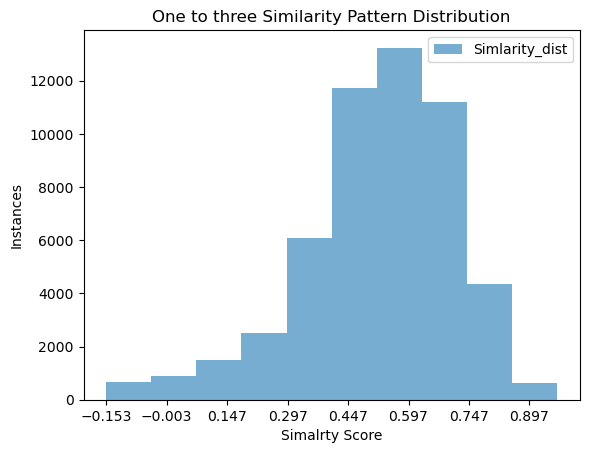

Sitelink + Keyword.1 + Keyword.3 / Headline.1    0.098847
Callout + Callout.1 + Keyword.2 / Description    0.098787
Description + Headline.1 + Keyword / Headline    0.097973
Headline + Headline.1 + Sitelink / Callout.1     0.096237
Description + Keyword.1 + Keyword.3 / Callout    0.094919
Keyword + Keyword.1 + Keyword.3 / Description    0.093377
Description + Headline + Keyword.4 / Callout     0.092128
Description + Keyword + Keyword.3 / Headline     0.092072
Description + Headline + Keyword.1 / Callout     0.091381
Description + Headline + Keyword.2 / Keyword     0.089273
Name: CTR, dtype: float64


In [114]:
if os.path.exists(QUAD_THREE_PATH) :
    quad_th_sim = pd.read_csv(QUAD_THREE_PATH,delimiter=",")
    print('present')
else:
    # Making tuples of 4 features 
    quad_res = tuple_maker(df_similarity,4)
    # Caculating similarity scores for each combination of 3 to 1 features 
    quad_res = similar_score(quad_res,df_similarity,3)
    quad_th_sim = pd.DataFrame.from_records(quad_res)
    quad_th_sim.to_csv(QUAD_THREE_PATH, index=False,) 
# Plotting Similarity distribution  
sim_potter (quad_th_sim,'One to three Similarity Pattern Distribution')
# Showing Correlation scores  
sim_corelation (quad_th_sim.copy(), df['CTR'])



present


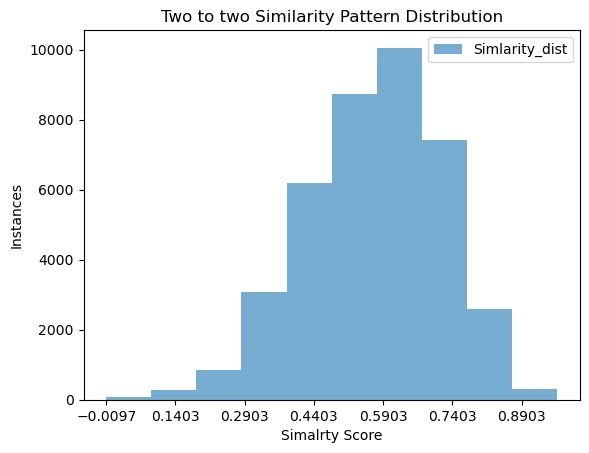

Headline + Callout / Keyword + Keyword.3           0.098080
Keyword.1 + Keyword.3 / Keyword.2 + Keyword.4      0.097631
Description + Keyword.4 / Callout + Keyword        0.096934
Headline.1 + Callout / Callout.1 + Keyword.3       0.095872
Description + Callout.1 / Keyword.1 + Keyword.3    0.095486
Headline.1 + Keyword.2 / Sitelink + Keyword.1      0.094624
Description + Keyword.2 / Keyword.1 + Keyword.3    0.094294
Headline.1 + Callout.1 / Sitelink + Keyword.1      0.092659
Headline + Keyword.3 / Sitelink + Keyword          0.090918
Description + Callout / Headline.1 + Keyword.1     0.090645
Name: CTR, dtype: float64


In [115]:
if os.path.exists(QUAD_TWO_PATH) :
    quad_tw_sim = pd.read_csv(QUAD_TWO_PATH,delimiter=",")
    print('present')
else:
    # Making tuples of 4 features 
    quad_res_t = tuple_maker(df_similarity,4)
    # Caculating similarity scores for each combination of 2 to 2 features 
    quad_res_t = similar_score(quad_res_t,df_similarity,2)
    quad_tw_sim = pd.DataFrame.from_records(quad_res_t)
    quad_tw_sim.to_csv(QUAD_TWO_PATH, index=False,) 
# Plotting similarity distribution  
sim_potter (quad_tw_sim,'Two to two Similarity Pattern Distribution')
# Showing Correlation scores  
sim_corelation (quad_tw_sim.copy(),df['CTR'])

### Pattern addition

In [116]:
def sementic_insert(f_path,boost_dict,orig_df):   
    if os.path.exists(f_path) :
        df_semnatic = pd.read_csv(f_path,delimiter=",")
    else:
        sim_df_scroing ={}
        df_semnatic = orig_df.copy()
        # Looping over feature similarity  dictionary  
        for comb in boost_dict:
            # Separating left feature column combinations from the right side
            split_comp_list = comb.split(' / ')
            # Splitting the feature column combination on both sides and adding to a list (creating two list made of the column names)
            division_comb = [com_str.split(' + ') for com_str in split_comp_list]
            # Extracting the column values of the left side from fabricated  data to then join together and preprocess
            dividend_nlp = [nlp(' '.join(v)) for v in random_df[division_comb[0]].values]
            # Extracting the column values of the right side from fabricated  data to then join together and preprocess
            divisior_nlp = [nlp(' '.join(r)) for r in random_df[division_comb[1]].values]
            # Calculating  similarity score for the combined vales 
            sim_df_scroing[comb] = [dvd.similarity(dvs) for dvd , dvs in zip(dividend_nlp ,divisior_nlp)]
        # Looping over each similarity score
        for cat in sim_df_scroing:
            # Adding a multiplication of 6 by the similarity  score to the ctr if it is above a given threshold 
            df_semnatic['CTR'] += [6 * sc if sc > boost_dict[cat] else 0 for sc in sim_df_scroing[cat] ]
        df_semnatic['CTR'].to_csv(f_path, index=False,)  
    return df_semnatic



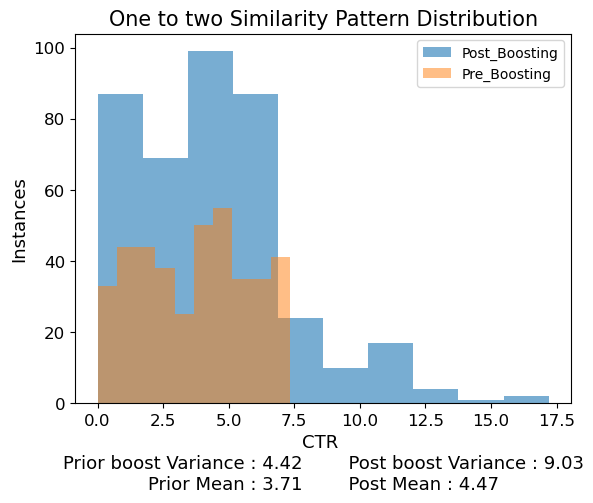

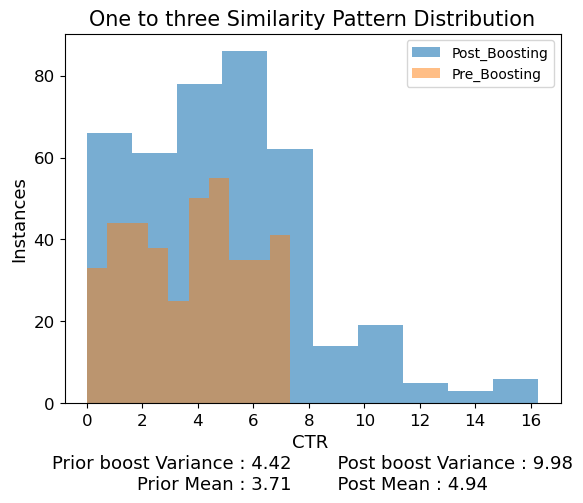

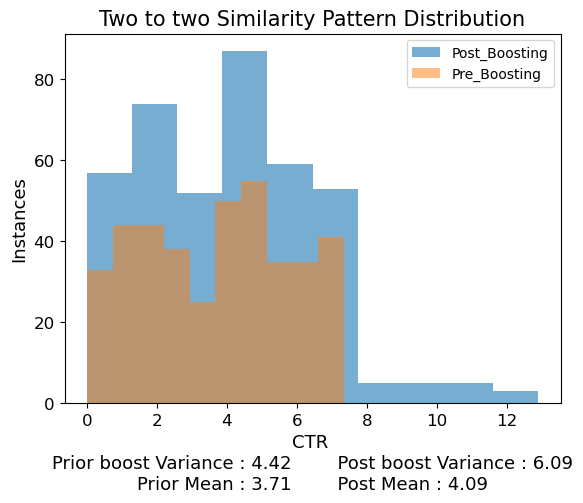

In [117]:
sem_res = []
# Defining title names for plots
plt_name = ['One to two Similarity Pattern Distribution','One to three Similarity Pattern Distribution' ,'Two to two Similarity Pattern Distribution']
# Defining CTR scores for plot
paths = [PATH_TRI_SEM,PATH_QUAD_TW_SEM,PATH_QUAUD_TH_SEM]
# Creating a dictionary of choosen tuple combination and threshold for CTR boosting
bost_dict = [{'Headline + Keyword.3 / Keyword.2': 0.8,'Sitelink + Keyword.1 / Keyword.4':0.72,'Headline.1 + Keyword.3 / Headline' :0.76 },
             {'Sitelink + Keyword.1 + Keyword.3 / Headline.1' : 0.75 , 'Callout + Callout.1 + Keyword.2 / Description': 0.73 , 'Description + Headline.1 + Keyword / Headline' : 0.65  },
             {'Headline + Callout / Keyword + Keyword.3' : 0.78 , 'Keyword.1 + Keyword.3 / Keyword.2 + Keyword.4': 0.94 , 'Description + Keyword.4 / Callout + Keyword' : 0.8  }]
# Loop over aech path and dictionary and plot name 
for sim_df,pth,n in zip(bost_dict,paths,plt_name) :
    # Calculate new CTR for each simalirty pattern 
    sem_res.append(sementic_insert(pth,sim_df,random_df))
    # Plot comparative  CTR values each similarity pattern 
    dist_plot(random_df['CTR'],sem_res[-1]['CTR'],n)

